# Notebook Overview

This notebook will be implementing the feature engineering I talked about in the previous notebook:
1. New strains
2. Social Restrictions.

It will then go through fitting the data to various ARIMA models and its variants, before selecting the best model.

This notebook will also cover the cost-benefit analysis, conclusions and recommendations.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px # for interactive plots
from statsmodels.graphics.tsaplots import plot_acf # to plot acf

from sklearn.metrics import mean_absolute_percentage_error # metric that's used to evaluate the performance of a time series model
import pmdarima as pm # for ARIMA model

# Feature Engineering

## Merging Datasets

In [2]:
#Reading in the datasets from previous notebooks to merge.
weather = pd.read_csv('../data/outputs/weather.csv')
trends = pd.read_csv('../data/outputs/googletrends.csv')
dengue_cases = pd.read_csv('../data/outputs/monthly_dengue_cases.csv')

In [3]:
#Converting each dataset's date column into a datetime object and setting it as index to merge on.
weather['Date'] = pd.to_datetime(weather['Date'])
weather = weather.set_index('Date')
trends['date'] = pd.to_datetime(trends['date'])
trends = trends.set_index('date')
dengue_cases['date'] = pd.to_datetime(dengue_cases['date'])
dengue_cases = dengue_cases.set_index('date')

In [4]:
#merging all 3 datasets together and assigning it to the variable dengue
dengue = pd.merge(weather,trends,left_index=True,right_index=True).merge(dengue_cases,left_index=True,right_index=True)
dengue

Rainfall Total (mm)  Mean Temperature (°C)  \
Date                                                      
2012-01-01                 106.1              26.703226   
2012-02-01                  83.6              27.137931   
2012-03-01                 313.4              27.016129   
2012-04-01                 260.6              27.613333   
2012-05-01                 292.0              28.174194   
...                          ...                    ...   
2022-08-01                 141.4              28.135484   
2022-09-01                 121.0              27.930000   
2022-10-01                 279.6              27.545161   
2022-11-01                 313.8              27.366667   
2022-12-01                 215.4              26.748387   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date                                                             
2012-01-01                      32.5                      21.5   
2012-02-01                      32.9                      22.7   
2012-03-01                      33.2                      21.1   
2012-04-01                      32.9                      21.9   
2012-05-01                      33.7                      22.0   
...                              ...                       ...   
2022-08-01                      33.2                      23.7   
2022-09-01                      32.6                      22.4   
2022-10-01                      34.6                      23.1   
2022-11-01                      33.9                      22.4   
2022-12-01                      32.7                      23.1   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  mean_rh  \
Date                                                                 
2012-01-01                9.083871                   64.8     87.3   
2012-02-01                9.889655                   42.1     85.6   
2012-03-01                6.864516                   56.9     87.3   
2012-04-01                6.380000                   50.0     85.1   
2012-05-01                6.996774                   53.6     83.1   
...                            ...                    ...      ...   
2022-08-01                8.616129                   53.7     77.4   
2022-09-01                7.360000                   51.9     76.9   
2022-10-01                6.251613                   40.4     78.7   
2022-11-01                6.950000                   51.9     79.9   
2022-12-01                8.758065                   42.6     81.2   

            search_dengue_fever  search_dengue_hospital  \
Date                                                      
2012-01-01                    8                      38   
2012-02-01                   10                       0   
2012-03-01                   10                       0   
2012-04-01                    8                       0   
2012-05-01                    9                       0   
...                         ...                     ...   
2022-08-01                   33                      33   
2022-09-01                   26                      10   
2022-10-01                   23                      14   
2022-11-01                   16                       0   
2022-12-01                   17                       0   

            search_dengue_symptoms  search_mosquito_aedes  \
Date                                                        
2012-01-01                       7                      8   
2012-02-01                       5                     22   
2012-03-01                      10                     17   
2012-04-01                       9                     26   
2012-05-01                       9                     16   
...                            ...                    ...   
2022-08-01                      32                     23   
2022-09-01                      26                     16   
2022-10-01                      23                     12   
2022-11-01                      16  

Here is my merged dataset with trends, weather info, and number of dengue cases in one dataframe.

## Feature Engineering - New Strains

Recall that the following years had a new strain emerge:

1. [2013 Dengue Outbreak with the peak in June](https://en.wikipedia.org/wiki/2013_dengue_outbreak_in_Singapore#cite_note-10)
    1. [Outbreak was due to an increase in the DENV-1 serotype of the dengue virus. Because that strain was less common, the local community was more susceptible to it.](https://en.wikipedia.org/wiki/2013_dengue_outbreak_in_Singapore#cite_note-8_)
1. [2014 Dengue Outbreak](https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-016-1606-z)
    1. [The same reason for the 2013 outbreak, the new strain caused an outbreak lasting two years from 2013 - 2014.](https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-016-1606-z)
1. [2016 Dengue Outbreak](https://www.straitstimes.com/singapore/environment/dengue-cases-cross-11000-mark-in-first-8-months-of-2016)
    1. [This outbreak was due to a new strain called DENV-2.](https://www.straitstimes.com/singapore/health/singapore-faces-dengue-threat-from-emergence-of-little-seen-strain)

1. [2020 Dengue Outbreak](https://en.wikipedia.org/wiki/2020_dengue_outbreak_in_Singapore)
    1. [Due to a new strain, DENV-3.](https://www.channelnewsasia.com/commentary/why-singapore-record-high-dengue-cases-covid-19-2020-coronavirus-687281)
1. [2022 Dengue Outbreak](https://www.straitstimes.com/singapore/health/singapore-records-19-dengue-deaths-in-2022-nearly-four-times-2021-s-toll)
    1. Due to the strain DENV-3 which was [not the prevalant serotype for over 30 years, which meant that herd immunity was still low.](https://www.dovepress.com/singapores-dengue-outbreak-amidst-the-covid-19-pandemic-challenges-res-peer-reviewed-fulltext-article-IDR)


**For each of the months in these years, I will assign them a value of 1 for the new feature titled new_strain while the other years will be assigned a value of 0**

1. Note that for the year 2021 the number of dengue cases is low compared to the years it is between, 2020 and 2022 (refer to lineplot below). This is even though it should have high cases as the DENV-3 dengue strain is still credited as the reason for the high number of dengue cases in 2022, because if it is causing high cases in 2022, how would it not have caused high cases in 2021.

One such reason would be that [“Detection and reporting of dengue cases are also believed to have been impacted by reduced access to health facilities, and a hesitancy to seek medical care at facilities due to concern of possible exposure to COVID-19 patients”. - World Health Organisation Spokesperson](https://www.channelnewsasia.com/asia/dengue-fever-plummet-southeast-asia-2021-covid-19-lockdown-1949581)

There are more reasons for this according to [professionals which can be found here.](https://www.channelnewsasia.com/asia/dengue-fever-plummet-southeast-asia-2021-covid-19-lockdown-1949581)

Regardless of the reasons, since the number of dengue cases are low for the year, I will list the value for this year as 0 even though there was a new strain present as the purpose of this new feature is to help the model predict the number of dengue cases.

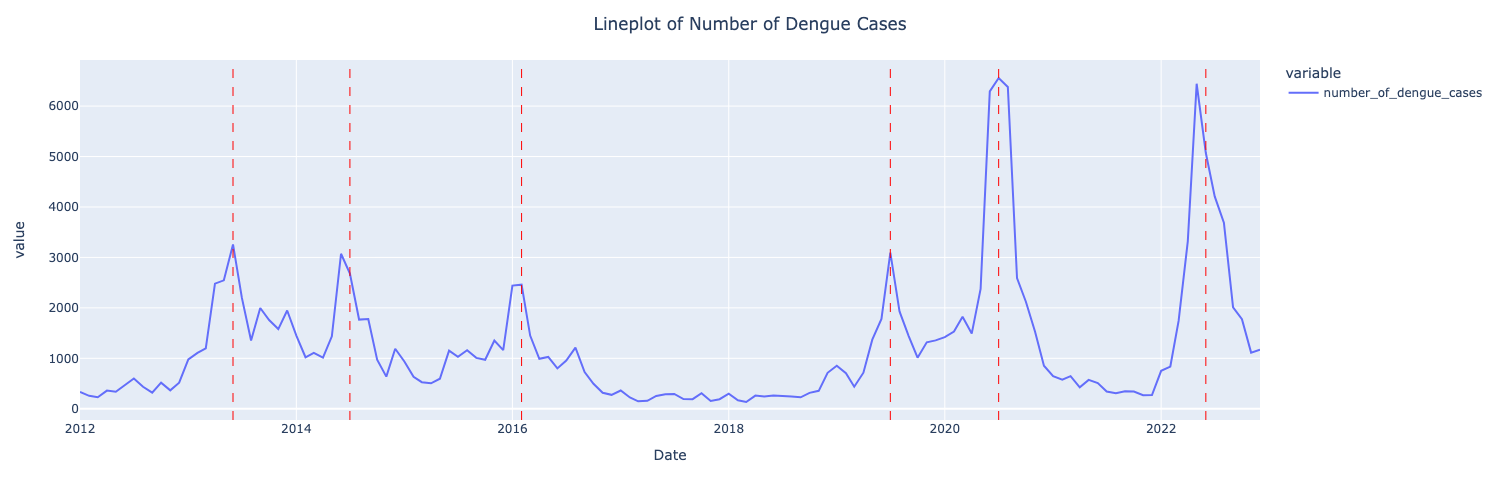

In [5]:
fig = px.line(dengue['number_of_dengue_cases'])

spike_dates = ['2013-06-01', '2014-07-01', '2016-02-01', '2019-07-01', '2020-07-01', '2022-06-01']
# Add vertical red lines to the plot
for value in spike_dates:
    fig.add_shape(
        type="line",
        xref="x",
        yref="paper",
        x0=value,
        y0=0,
        x1=value,
        y1=1,
        line=dict(color="red", width=1, dash="dash"),
    )

# Update the layout to increase the size of the figure
fig.update_layout(
    width=1500,  # Specify the width of the figure
    height=500,  # Specify the height of the figure
    title='Lineplot of Number of Dengue Cases',
    title_x = 0.5
)

fig.show()

Notice the low number of cases in 2021, even though DENV-3 is still present.

In [6]:
# Create a new column 'new_strain' and initialize it with 0
dengue['new_strain'] = 0

# Assign the value of 1 to the years with a new strain
dengue.loc[(dengue.index >= '2013-01-01') & (dengue.index <= '2014-12-01') | 
       (dengue.index >= '2016-01-01') & (dengue.index <= '2016-12-01') |
       (dengue.index >= '2020-01-01') & (dengue.index <= '2020-12-01') |
       (dengue.index >= '2022-01-01') & (dengue.index <= '2022-12-01'),
        'new_strain'] = 1

In [7]:
dengue

Rainfall Total (mm)  Mean Temperature (°C)  \
Date                                                      
2012-01-01                 106.1              26.703226   
2012-02-01                  83.6              27.137931   
2012-03-01                 313.4              27.016129   
2012-04-01                 260.6              27.613333   
2012-05-01                 292.0              28.174194   
...                          ...                    ...   
2022-08-01                 141.4              28.135484   
2022-09-01                 121.0              27.930000   
2022-10-01                 279.6              27.545161   
2022-11-01                 313.8              27.366667   
2022-12-01                 215.4              26.748387   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date                                                             
2012-01-01                      32.5                      21.5   
2012-02-01                      32.9                      22.7   
2012-03-01                      33.2                      21.1   
2012-04-01                      32.9                      21.9   
2012-05-01                      33.7                      22.0   
...                              ...                       ...   
2022-08-01                      33.2                      23.7   
2022-09-01                      32.6                      22.4   
2022-10-01                      34.6                      23.1   
2022-11-01                      33.9                      22.4   
2022-12-01                      32.7                      23.1   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  mean_rh  \
Date                                                                 
2012-01-01                9.083871                   64.8     87.3   
2012-02-01                9.889655                   42.1     85.6   
2012-03-01                6.864516                   56.9     87.3   
2012-04-01                6.380000                   50.0     85.1   
2012-05-01                6.996774                   53.6     83.1   
...                            ...                    ...      ...   
2022-08-01                8.616129                   53.7     77.4   
2022-09-01                7.360000                   51.9     76.9   
2022-10-01                6.251613                   40.4     78.7   
2022-11-01                6.950000                   51.9     79.9   
2022-12-01                8.758065                   42.6     81.2   

            search_dengue_fever  search_dengue_hospital  \
Date                                                      
2012-01-01                    8                      38   
2012-02-01                   10                       0   
2012-03-01                   10                       0   
2012-04-01                    8                       0   
2012-05-01                    9                       0   
...                         ...                     ...   
2022-08-01                   33                      33   
2022-09-01                   26                      10   
2022-10-01                   23                      14   
2022-11-01                   16                       0   
2022-12-01                   17                       0   

            search_dengue_symptoms  search_mosquito_aedes  \
Date                                                        
2012-01-01                       7                      8   
2012-02-01                       5                     22   
2012-03-01                      10                     17   
2012-04-01                       9                     26   
2012-05-01                       9                     16   
...                            ...                    ...   
2022-08-01                      32                     23   
2022-09-01                      26                     16   
2022-10-01                      23                     12   
2022-11-01                      16  

New feature created with 1 for the years where a new strain was present and 0 for years where no new strain was present.

## Feature Engineering - Social Restrictions

I will now feature engineer a feature called social restrictions similar to how new strains was made.

**Apr 2020 - Dec 2022 will be assigned a value of 1 to indicate that social restrictions were in place and the other years will be assigned a value of 0.**

As to why Apr 2020 - 2022 and not just the main circuit breaker period in Singapore will be assigned a value of 1, the justification is due to Singapore implementing many different kinds of restrictions with different names, but ultimately still having social restrictions albeit not as severe as circuit breaker.

The social restrictions were ended only from 13 Feb 2023 onwards and hence we will label all months from Apr 2020 - Dec 2022 as having social restrictions in place.

[**Full Breakdown of Singapore's Social Restrictions**](https://www.straitstimes.com/singapore/two-years-of-twists-and-turns-a-timeline-of-singapores-covid-19-measures)
1. Circuit Breaker (7 Apr 2020 - 1 Jun 2020)
1. Phase 1 (2 Jun 2020 - 18 Jun 2020)
1. Phase 2 (19 Jun 2020 - 27 Dec 2020)
1. Phase 3 (28 Dec 2020 - 7 May 2021)
1. Reverting back to Phase 2 due to increased COVID cases (8 May 2021 - 15 May 2021)
1. Phase 2 Heightened Alert (16 May 2021 - 13 Jun 2021)
1. Phase 3 Heightened Alert (22 Jul 2021 - 9 Aug 2021)
1. Reverting back to Phase 2 Heightened Alert again (22 Jul 2021 - 9 Aug 2021)
1. "Preparatory Stage of Transition" (10 Aug 2021 - 26 Sep 2021)
1. Stabilisation Phase (27 Sep 2021 - 21 Nov 2021)
1. Transition Phase (22 Nov 2021 - 25 Apr 2022)
1. 'COVID-19 Resilient Nation / Acute Phase' (26 Apr 2022 - 12 Feb 2023)
1. **Endemic Phase (13 Feb 2023 onwards) where there were no more social restrictions** 

In [8]:
# Create a new column 'new_strain' and initialize it with 0
dengue['social_restrictions'] = 0

# Assign the value of 1 to the months with social restrictions
dengue.loc[(dengue.index >= '2020-04-01') & (dengue.index <= '2022-12-01'),'social_restrictions'] = 1

In [9]:
dengue

Rainfall Total (mm)  Mean Temperature (°C)  \
Date                                                      
2012-01-01                 106.1              26.703226   
2012-02-01                  83.6              27.137931   
2012-03-01                 313.4              27.016129   
2012-04-01                 260.6              27.613333   
2012-05-01                 292.0              28.174194   
...                          ...                    ...   
2022-08-01                 141.4              28.135484   
2022-09-01                 121.0              27.930000   
2022-10-01                 279.6              27.545161   
2022-11-01                 313.8              27.366667   
2022-12-01                 215.4              26.748387   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date                                                             
2012-01-01                      32.5                      21.5   
2012-02-01                      32.9                      22.7   
2012-03-01                      33.2                      21.1   
2012-04-01                      32.9                      21.9   
2012-05-01                      33.7                      22.0   
...                              ...                       ...   
2022-08-01                      33.2                      23.7   
2022-09-01                      32.6                      22.4   
2022-10-01                      34.6                      23.1   
2022-11-01                      33.9                      22.4   
2022-12-01                      32.7                      23.1   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  mean_rh  \
Date                                                                 
2012-01-01                9.083871                   64.8     87.3   
2012-02-01                9.889655                   42.1     85.6   
2012-03-01                6.864516                   56.9     87.3   
2012-04-01                6.380000                   50.0     85.1   
2012-05-01                6.996774                   53.6     83.1   
...                            ...                    ...      ...   
2022-08-01                8.616129                   53.7     77.4   
2022-09-01                7.360000                   51.9     76.9   
2022-10-01                6.251613                   40.4     78.7   
2022-11-01                6.950000                   51.9     79.9   
2022-12-01                8.758065                   42.6     81.2   

            search_dengue_fever  search_dengue_hospital  \
Date                                                      
2012-01-01                    8                      38   
2012-02-01                   10                       0   
2012-03-01                   10                       0   
2012-04-01                    8                       0   
2012-05-01                    9                       0   
...                         ...                     ...   
2022-08-01                   33                      33   
2022-09-01                   26                      10   
2022-10-01                   23                      14   
2022-11-01                   16                       0   
2022-12-01                   17                       0   

            search_dengue_symptoms  search_mosquito_aedes  \
Date                                                        
2012-01-01                       7                      8   
2012-02-01                       5                     22   
2012-03-01                      10                     17   
2012-04-01                       9                     26   
2012-05-01                       9                     16   
...                            ...                    ...   
2022-08-01                      32                     23   
2022-09-01                      26                     16   
2022-10-01                      23                     12   
2022-11-01                      16  

New feature called social_restrictions created.

# Baseline Model

With the new features engineered, I am ready to fit the data to a baseline model and improve performance from there.

I will first start with using an ARIMA model with just dengue cases from 2012 - 2021 to try and predict 2022 cases.

**I have decided on predicting 1 year's worth of dengue cases as this would be a sufficient lead time for the NEA to react accordingly, be it stepping up household inspections, or initiating marketing campaigns to coincide with the predicted amount of dengue cases.**

If predicting a year's worth of dengue cases leads to poor performance, I will reduce the prediction period if it improves performance, and I will select the best model based on the best MAPE score taking into account how far into the future the model is predicting.

In [10]:
dengue.head()

Rainfall Total (mm)  Mean Temperature (°C)  \
Date                                                      
2012-01-01                 106.1              26.703226   
2012-02-01                  83.6              27.137931   
2012-03-01                 313.4              27.016129   
2012-04-01                 260.6              27.613333   
2012-05-01                 292.0              28.174194   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date                                                             
2012-01-01                      32.5                      21.5   
2012-02-01                      32.9                      22.7   
2012-03-01                      33.2                      21.1   
2012-04-01                      32.9                      21.9   
2012-05-01                      33.7                      22.0   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  mean_rh  \
Date                                                                 
2012-01-01                9.083871                   64.8     87.3   
2012-02-01                9.889655                   42.1     85.6   
2012-03-01                6.864516                   56.9     87.3   
2012-04-01                6.380000                   50.0     85.1   
2012-05-01                6.996774                   53.6     83.1   

            search_dengue_fever  search_dengue_hospital  \
Date                                                      
2012-01-01                    8                      38   
2012-02-01                   10                       0   
2012-03-01                   10                       0   
2012-04-01                    8                       0   
2012-05-01                    9                       0   

            search_dengue_symptoms  search_mosquito_aedes  \
Date                                                        
2012-01-01                       7                      8   
2012-02-01                       5                     22   
2012-03-01                      10                     17   
2012-04-01                       9                     26   
2012-05-01                       9                     16   

            search_mosquito_bite  search_dengue  search_dengue_treatment  \
Date                                                                       
2012-01-01                    13              9                        0   
2012-02-01                    22             11                       42   
2012-03-01                    33              9                        0   
2012-04-01                    34              9                        0   
2012-05-01                     8             12                        0   

            number_of_dengue_cases  new_strain  social_restrictions  
Date                                                                 
2012-01-01                     332           0                    0  
2012-02-01                     257           0                    0  
2012-03-01                     229           0                    0  
2012-04-01                     360           0                    0  
2012-05-01                     337           0                    0

In [11]:
# defining our train and test sets based on date in a way that they don't overlap
y = dengue['number_of_dengue_cases'] # variable to forecast

y_train = y[:'2021']  # train set - from earliest date available on dataset to end of 2021
y_test = y['2022':] # test set - everything from 2022 onwards

print(y_train.head(),y_train.tail()) 
print(y_test.head())

Date
2012-01-01    332
2012-02-01    257
2012-03-01    229
2012-04-01    360
2012-05-01    337
Name: number_of_dengue_cases, dtype: int64 Date
2021-08-01    306
2021-09-01    348
2021-10-01    340
2021-11-01    268
2021-12-01    272
Name: number_of_dengue_cases, dtype: int64
Date
2022-01-01     752
2022-02-01     837
2022-03-01    1741
2022-04-01    3319
2022-05-01    6443
Name: number_of_dengue_cases, dtype: int64


Visually confirming that the train test split is correctly done, and it is. The train set is from 2012 - 2021 and the test set is from 2022 onwards.

In [12]:
# ensure majority of the samples are used for model training
print(y_train.shape) 
print(y_test.shape) 

(120,)
(12,)


**Note that I am using AutoARIMA to determine whether my data needs to be differenced in order for it to be stationary. I will be using AutoARIMA to do this in place of the Augmented Dickey-Fuller Test as it achieves the same thing.**

In [13]:
# Fit Auto ARIMA  with hyperparameters to tune: p (AR), q (MA) and d (I)
arima_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

arima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2031.348, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1893.105, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1945.033, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2109.436, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1887.105, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1888.711, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1889.011, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1888.872, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1890.521, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1893.646, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.320 seconds


AutoARIMA(max_p=10, max_q=10, n_fits=50, random_state=20, start_p=0, start_q=0,
          trace=True)

**Note that the AutoArima model has chosen d = 0 which means that no differencing was applied to the data and this means that my data is already stationary or does not exhibit any significant trend or seasonality.**

In [14]:
# Create helper function to help make predictions and plot the results 
def plot_forecast(y_train, y_test, arima_model,model_name,X_test = None,): # the optional argument of X_test is because the baseline model won't be using any exogenous features.
    # Generate len(y_test) number of predictions
    y_pred = pd.Series(arima_model.predict(n_periods = len(y_test),X=X_test), index = y_test.index) # we want as many future data point predictions as there are in y_test

    # Plot data.
    plt.figure(figsize=(15,8),dpi = 150)

    # Plot training data. 
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data. 
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

    # Plot predicted data
    plt.plot(y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    # Find the MAPE (mean abs percentage error) of the predictions
    mape = mean_absolute_percentage_error(y_test, y_pred) 

    plt.title(label = f'Dengue Cases Predictions of {model_name}\n MAPE: {mape:.2f}', fontsize=16) 
    plt.legend(fontsize = 20, loc = 'upper left')
    plt.xlabel('Date')
    plt.ylabel('No. of Dengue Cases'); 

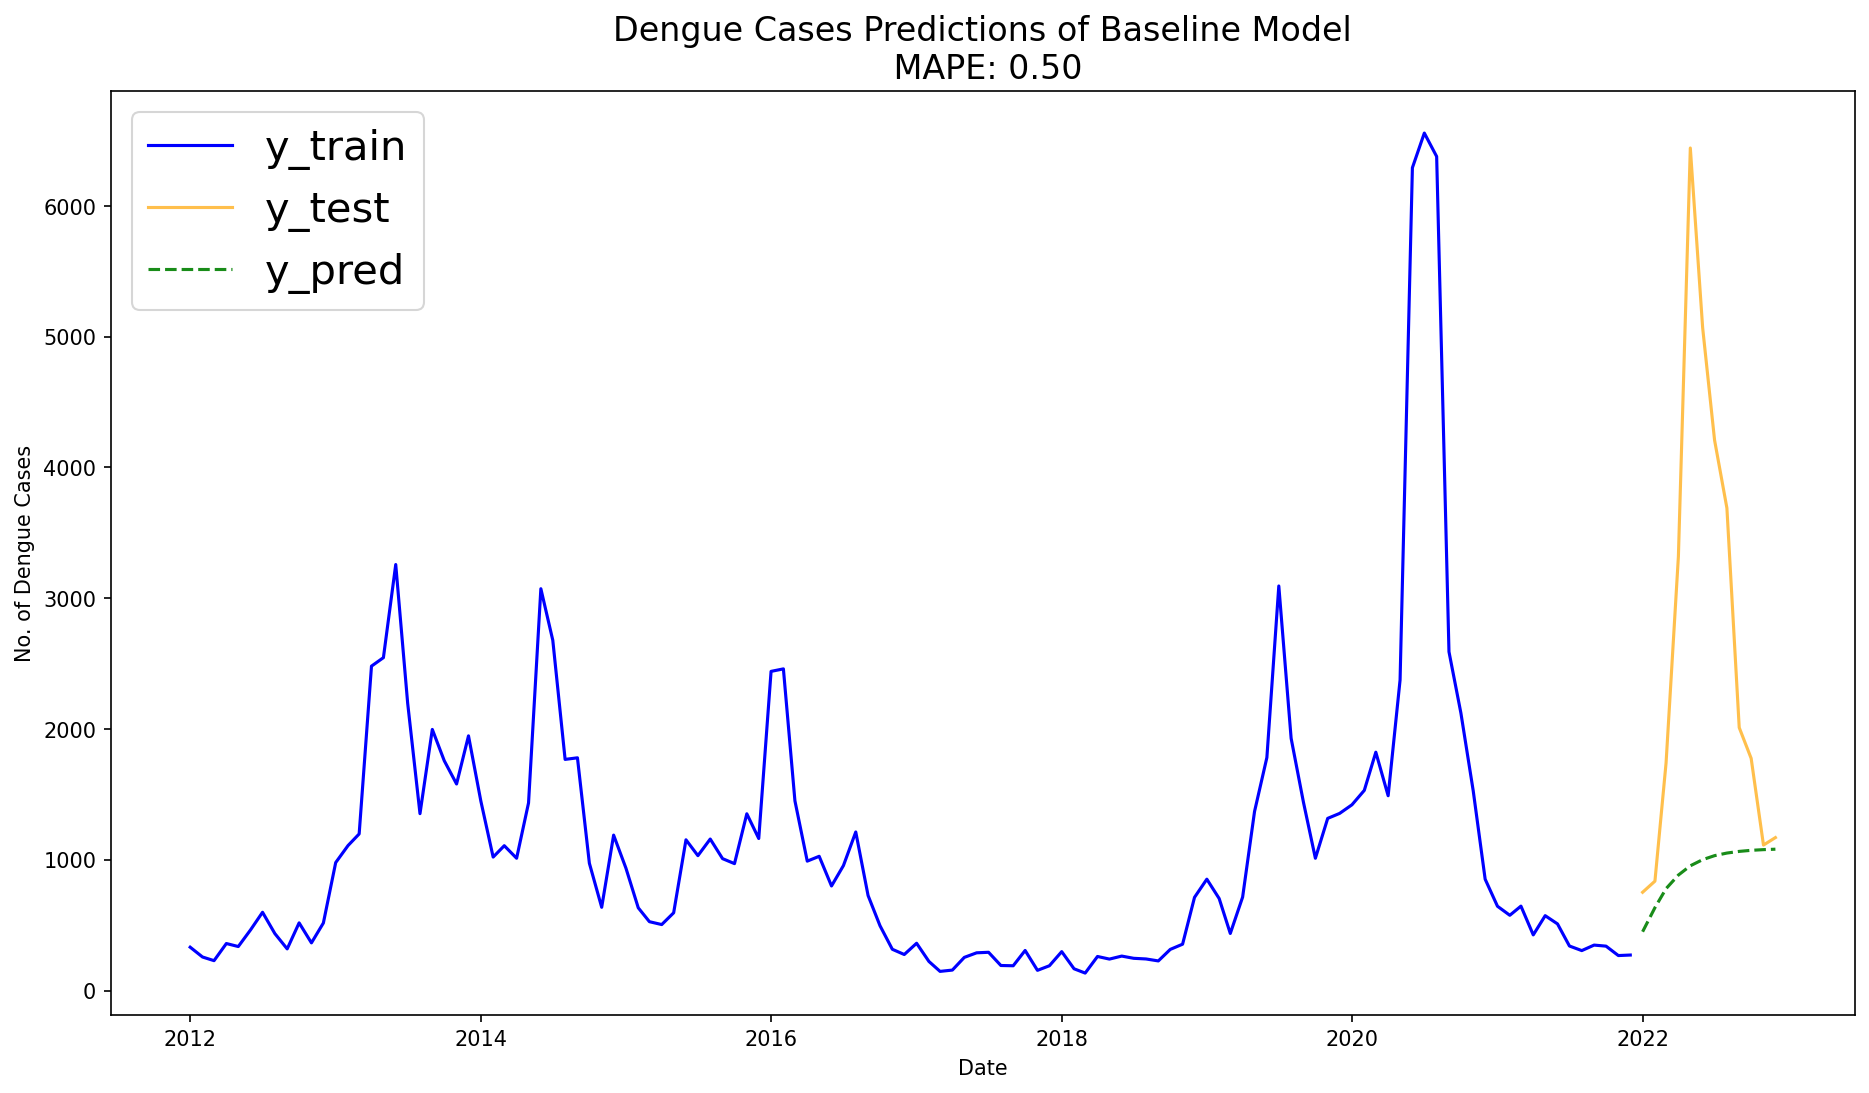

In [15]:
# invoke the helper function to visualize Auto ARIMA model predictions
plot_forecast(y_train, y_test, arima_model, 'Baseline Model')

## Interpretation of Baseline Model Results

From the MAPE score of 0.50, the baseline model's predictions is off by 50% from the actual values, which is a poor result.

The plot also visually shows how the predictions are nowhere near predictive of the actual cases.

I will now try an improved model using ARIMAX to include the exogenous features that I have in the data.

# Improved Model #1 - ARIMAX

**Important Note**

As I am now including my exogenous features, I will need to deliberately lag or shift my X values to make sense for the forecasting.

As I am predicting a year into the future, I will shift my exogenous features by a year as well. The reason I need to do this is that if im predicting cases one year into the future, I can't use information which I wouldn't have access to such as google search terms and weather information of the same month. I also chose a year as we know that there is a peak season of dengue every June - July, by using the same month from the previous year, the hope is that the variables from the previous year's months would be the same in the month we are trying to predict.

Therefore, I will shift my exogenous features one year into the future. For example 2012 exogenous features will be shifted a year forward to become 2013 data.

In [16]:
dengue_shifted_1_year = dengue.copy() # creating a copy of the original dataset to shift my exogenous features

In [17]:
dengue_shifted_1_year = dengue_shifted_1_year.drop('number_of_dengue_cases',axis =1).shift(12).join(dengue_shifted_1_year['number_of_dengue_cases']).dropna()

In [18]:
dengue.iloc[0:1]

Rainfall Total (mm)  Mean Temperature (°C)  \
Date                                                      
2012-01-01                 106.1              26.703226   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date                                                             
2012-01-01                      32.5                      21.5   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  mean_rh  \
Date                                                                 
2012-01-01                9.083871                   64.8     87.3   

            search_dengue_fever  search_dengue_hospital  \
Date                                                      
2012-01-01                    8                      38   

            search_dengue_symptoms  search_mosquito_aedes  \
Date                                                        
2012-01-01                       7                      8   

            search_mosquito_bite  search_dengue  search_dengue_treatment  \
Date                                                                       
2012-01-01                    13              9                        0   

            number_of_dengue_cases  new_strain  social_restrictions  
Date                                                                 
2012-01-01                     332           0                    0

This is the original value for 2012-01-01. It will become the value for 2013-12-01 which is 1 year in the future in the shifted dataset.

In [19]:
dengue_shifted_1_year.iloc[0:1]

Rainfall Total (mm)  Mean Temperature (°C)  \
Date                                                      
2013-01-01                 106.1              26.703226   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date                                                             
2013-01-01                      32.5                      21.5   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  mean_rh  \
Date                                                                 
2013-01-01                9.083871                   64.8     87.3   

            search_dengue_fever  search_dengue_hospital  \
Date                                                      
2013-01-01                  8.0                    38.0   

            search_dengue_symptoms  search_mosquito_aedes  \
Date                                                        
2013-01-01                     7.0                    8.0   

            search_mosquito_bite  search_dengue  search_dengue_treatment  \
Date                                                                       
2013-01-01                  13.0            9.0                      0.0   

            new_strain  social_restrictions  number_of_dengue_cases  
Date                                                                 
2013-01-01         0.0                  0.0                     979

**Notice that the exogenous features values are the same, just that the date has changed from 2012-01-01 to 2013-01-01. The date is to indicate the period for the target variable (i.e. no. of dengue cases), and not the exogenous features anymore as it has been shifted a year.**

I will now fit both the target variable and exogenous features to an ARIMAX model to see if it improves model performance.

In [20]:
# Adding Exogenous variables to our model
X = dengue_shifted_1_year.drop('number_of_dengue_cases',axis = 1)

# split `X` train and test for same timeframe as `y`
X_train = X[:'2021']
X_test = X['2022':]

# same steps as earlier to split `y`
y = dengue_shifted_1_year['number_of_dengue_cases']

y_train = y[:'2021']
y_test = y['2022':]

In [21]:
# Fit Auto ARIMA

arimax_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

arimax_model.fit(y_train, X_train) # we were only fitting purely on y_train before, but now we are fitting on y_train and X_train to include exogenous features

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1818.055, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1725.173, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1754.906, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1816.055, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1726.926, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1728.029, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1730.013, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1722.941, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1725.854, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1726.918, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1755.845, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1727.897, Time=0.25 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.242 seconds


AutoARIMA(max_P=10, max_p=10, max_q=10, n_fits=50, random_state=20, start_P=0,
          start_p=0, start_q=0, trace=True)

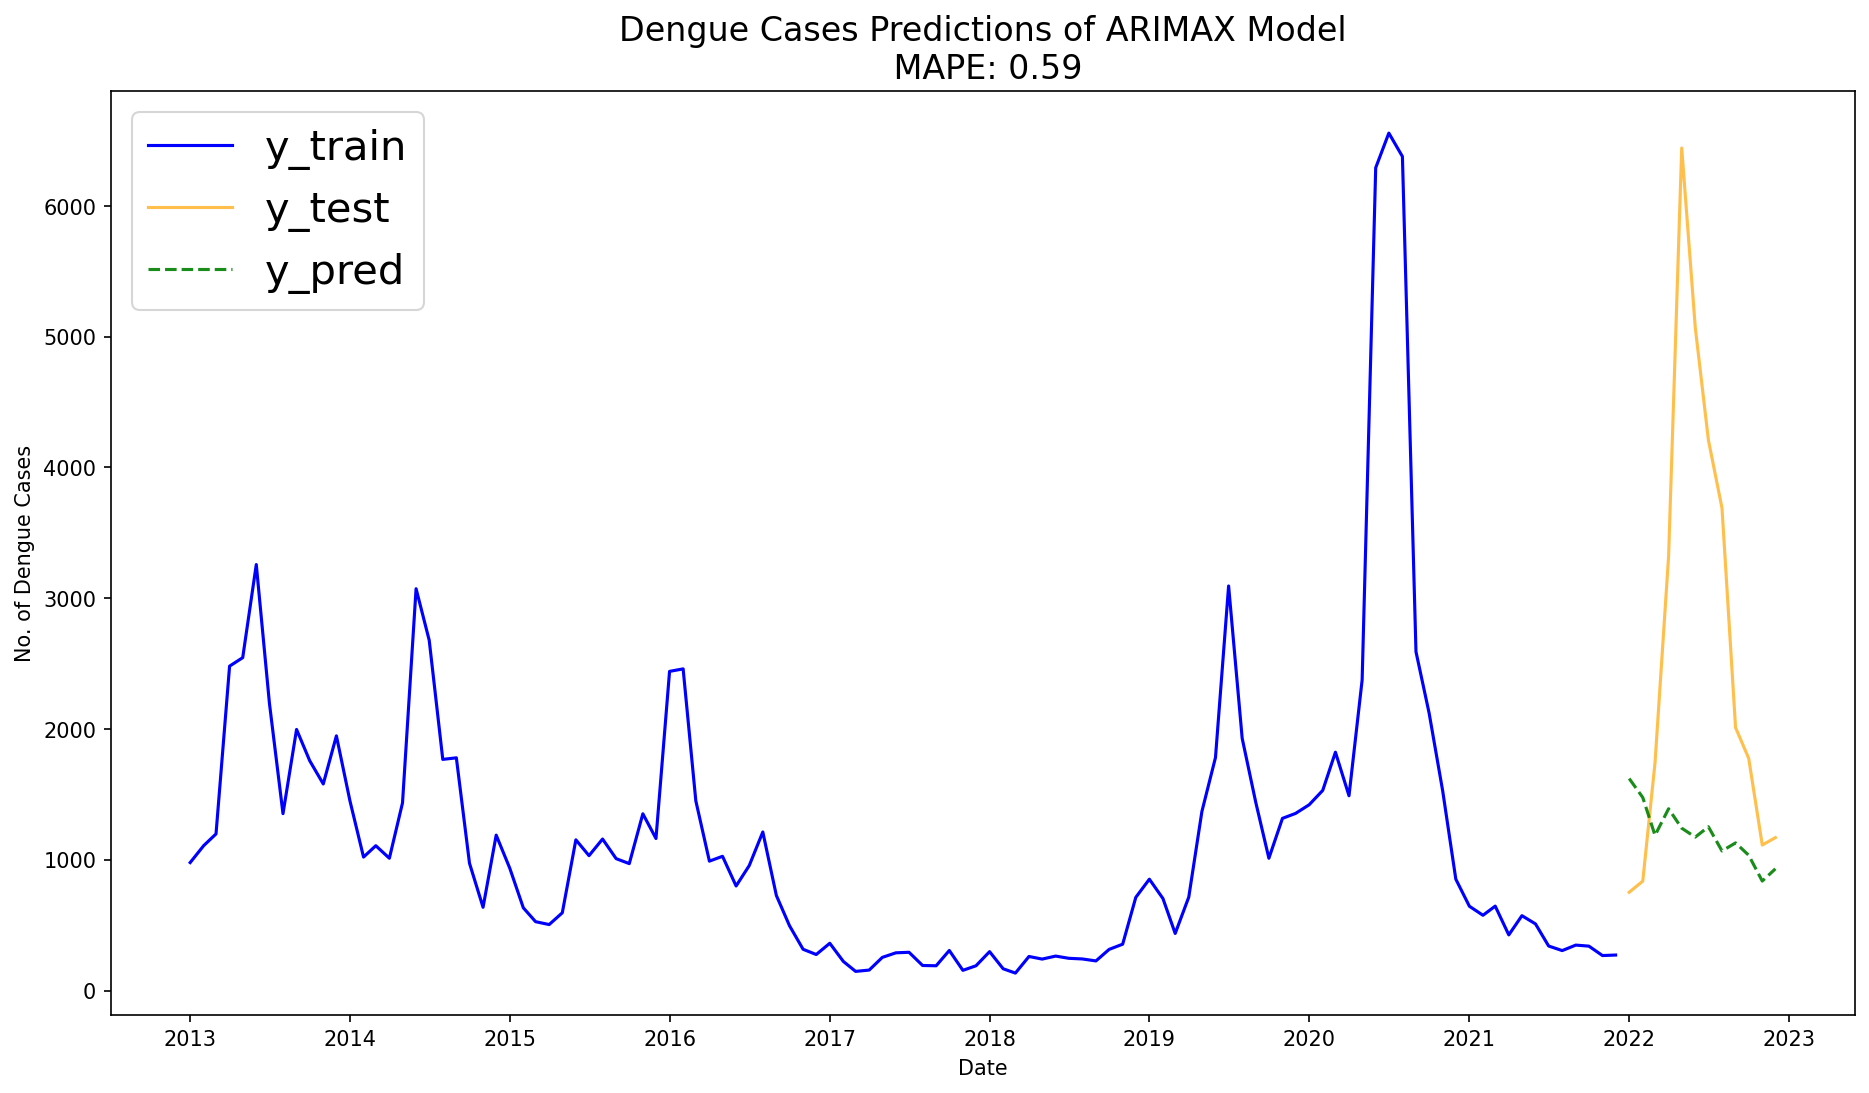

In [22]:
plot_forecast(y_train, y_test, arimax_model,'ARIMAX Model', X_test);# calling plot_forecast function

The MAPE score has worsened from 0.50 to 0.59, and the visualisation is just as bad as the baseline model's visualisation where it is not matching the actual values at all.

In [23]:
arimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -843.471
Date:                Fri, 19 May 2023   AIC                           1722.941
Time:                        21:47:21   BIC                           1771.220
Sample:                    01-01-2013   HQIC                          1742.516
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
 Rainfall Total (mm)         0.3690      1.271      0.290      0.772      -2.122       2.860
Mean Temperature (°C)      107.6182    190.649      0.564      0.572    -266.048     481.284
Maximum Temperature (°C)    -9.4959    160.546     -0.059      0.953    -324.161     305.169
Minimum Temperature (°C)   -16.1661    139.672     -0.116      0.908    -289.919     257.587
Mean Wind Speed (km/h)      28.2971     66.971      0.423      0.673    -102.963     159.558
Max Wind Speed (km/h)        0.6235     13.398      0.047      0.963     -25.636      26.883
mean_rh                    -16.7330     35.917     -0.466      0.641     -87.129      53.663
search_dengue_fever        168.0327     72.030      2.333      0.020      26.856     309.210
search_dengue_hospital       1.5207      4.419      0.344      0.731      -7.140      10.182
search_dengue_symptoms      20.7954     26.138      0.796      0.426     -30.435      72.025
search_mosquito_aedes        1.2047     10.501      0.115      0.909     -19.376      21.785
search_mosquito_bite        -5.2597      9.682     -0.543      0.587     -24.236      13.716
search_dengue             -161.7267     75.111     -2.153      0.031    -308.942     -14.512
search_dengue_treatment     -1.1538      5.266     -0.219      0.827     -11.476       9.168
new_strain               -1249.4860    425.726     -2.935      0.003   -2083.893    -415.079
social_restrictions       -303.4142   1167.290     -0.260      0.795   -2591.261    1984.432
ar.L1                        0.7865      0.074     10.656      0.000       0.642       0.931
sigma2                    3.706e+05   4.89e+04      7.574      0.000    2.75e+05    4.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):               924.60
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             2.08
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Also, from the model summary, we can see which features had a p value of more than 0.05 which means that the features may not have a significant impact on the model and can be removed.

I will try removing these features in an upcoming model to see if it improves model performace.

# Improved Model #2 - SARIMAX with features removed

Recall that many features had p values greater than 0.05 which means that these features might not have a significant impact on the model.

I will now remove these insignificant features and run it through a SARIMAX model this time and not just ARIMAX to include seasonality inside the model to see if model performance improves.

In [24]:
arimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -843.471
Date:                Fri, 19 May 2023   AIC                           1722.941
Time:                        21:47:21   BIC                           1771.220
Sample:                    01-01-2013   HQIC                          1742.516
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
 Rainfall Total (mm)         0.3690      1.271      0.290      0.772      -2.122       2.860
Mean Temperature (°C)      107.6182    190.649      0.564      0.572    -266.048     481.284
Maximum Temperature (°C)    -9.4959    160.546     -0.059      0.953    -324.161     305.169
Minimum Temperature (°C)   -16.1661    139.672     -0.116      0.908    -289.919     257.587
Mean Wind Speed (km/h)      28.2971     66.971      0.423      0.673    -102.963     159.558
Max Wind Speed (km/h)        0.6235     13.398      0.047      0.963     -25.636      26.883
mean_rh                    -16.7330     35.917     -0.466      0.641     -87.129      53.663
search_dengue_fever        168.0327     72.030      2.333      0.020      26.856     309.210
search_dengue_hospital       1.5207      4.419      0.344      0.731      -7.140      10.182
search_dengue_symptoms      20.7954     26.138      0.796      0.426     -30.435      72.025
search_mosquito_aedes        1.2047     10.501      0.115      0.909     -19.376      21.785
search_mosquito_bite        -5.2597      9.682     -0.543      0.587     -24.236      13.716
search_dengue             -161.7267     75.111     -2.153      0.031    -308.942     -14.512
search_dengue_treatment     -1.1538      5.266     -0.219      0.827     -11.476       9.168
new_strain               -1249.4860    425.726     -2.935      0.003   -2083.893    -415.079
social_restrictions       -303.4142   1167.290     -0.260      0.795   -2591.261    1984.432
ar.L1                        0.7865      0.074     10.656      0.000       0.642       0.931
sigma2                    3.706e+05   4.89e+04      7.574      0.000    2.75e+05    4.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):               924.60
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             2.08
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
#Insignificant features with p-values greater than 0.05 from the summary above which I will remove:
features_to_remove = [' Rainfall Total (mm)',
                      'Mean Temperature (°C)',
                      'Maximum Temperature (°C)',
                      'Minimum Temperature (°C)',
                      'Mean Wind Speed (km/h)',
                      'Max Wind Speed (km/h)',
                      'mean_rh',
                      'search_dengue_hospital',
                      'search_dengue_symptoms',
                      'search_mosquito_aedes',
                      'search_mosquito_bite',
                      'search_dengue_treatment',
                      'social_restrictions',
                     ]

In [26]:
dengue_features_removed = dengue_shifted_1_year.copy() # creating copy of original dataframe
dengue_features_removed = dengue_shifted_1_year.drop(features_to_remove,axis=1)# dropping insignificant features
dengue_features_removed

search_dengue_fever  search_dengue  new_strain  \
Date                                                         
2013-01-01                  8.0            9.0         0.0   
2013-02-01                 10.0           11.0         0.0   
2013-03-01                 10.0            9.0         0.0   
2013-04-01                  8.0            9.0         0.0   
2013-05-01                  9.0           12.0         0.0   
...                         ...            ...         ...   
2022-08-01                  9.0            9.0         0.0   
2022-09-01                 10.0           10.0         0.0   
2022-10-01                  9.0            9.0         0.0   
2022-11-01                  7.0            8.0         0.0   
2022-12-01                  5.0            5.0         0.0   

            number_of_dengue_cases  
Date                                
2013-01-01                     979  
2013-02-01                    1109  
2013-03-01                    1198  
2013-04-01                    2481  
2013-05-01                    2546  
...                            ...  
2022-08-01                    3690  
2022-09-01                    2011  
2022-10-01                    1776  
2022-11-01                    1113  
2022-12-01                    1170  

[120 rows x 4 columns]

New DataFrame with insignificant features dropped and the exogenous features still lagged for reasons previously stated.

In [27]:
# Adding Exogenous variables to our model
X = dengue_features_removed.drop('number_of_dengue_cases',axis = 1)

# split `X` train and test for same timeframe as `y`
X_train = X[:'2021']
X_test = X['2022':]

# same steps as earlier to split `y`
y = dengue_features_removed['number_of_dengue_cases']

y_train = y[:'2021']
y_test = y['2022':]

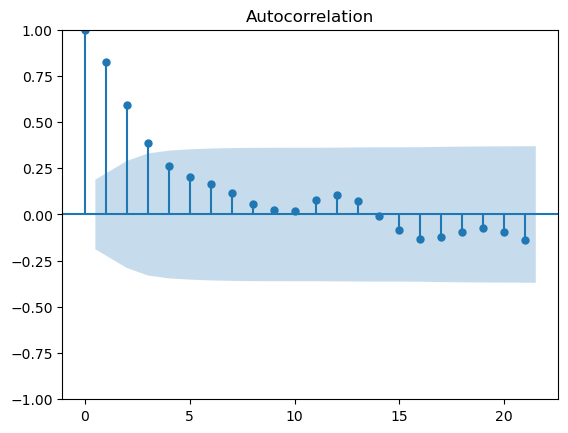

In [28]:
plot_acf(y_train);

To determine what values for m should be used, which is the seasonality paramter in the autoarima model, I checked using an autocorrelation plot.

From the plot I can see that there is significant correlation between points 2 - 4. I will try fitting a SARIMAX model with these points.

In [29]:
# Fit Auto ARIMA
features_removed_arimax_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           D=None,
                           start_Q=0, max_Q=10,
                           m=4, 
                           seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

features_removed_arimax_model.fit(y_train, X_train) # we were only fitting purely on y_train before, but now we are fitting on y_train and X_train to include exogenous features

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1806.925, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=1701.872, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=1737.135, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1824.023, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=1702.227, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=1704.119, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1707.258, Time=0.16 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=1701.564, Time=0.11 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=1704.774, Time=0.15 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=1714.928, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=1807.052, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=1696.866, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=1695.103, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=1696.913, Time=0.14 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept

AutoARIMA(m=4, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

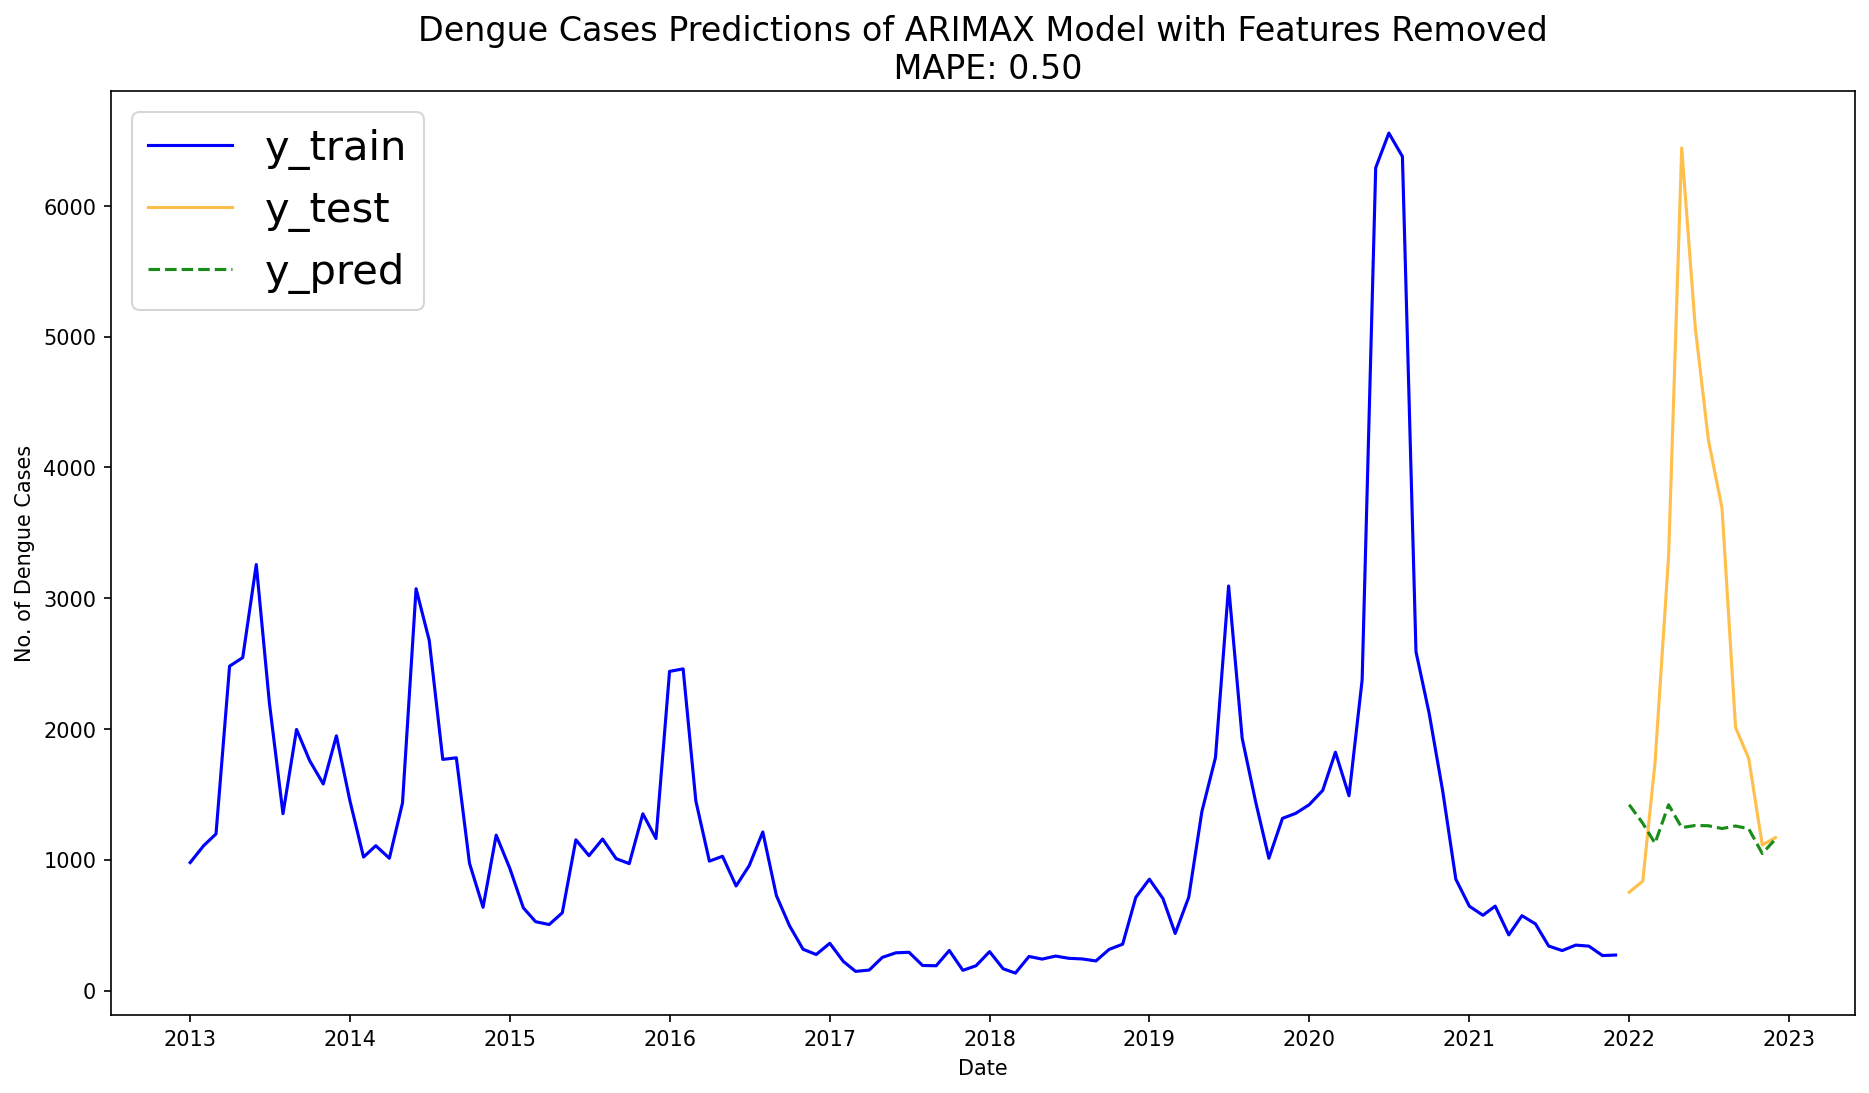

In [30]:
plot_forecast(y_train, y_test, features_removed_arimax_model,'ARIMAX Model with Features Removed', X_test);

The best seasonal parameter value was either 3 or 4 which gave me a MAPE score of 0.50 compared to 0.68 for a seasonal value of 2.

Regardless, the best score of 0.50 is still not good enough to be presented to the NEA. I will try other ways to improve model performance.

# Improved Model #3 - Using a Subset of the Data

Next I will try training the model using a subset of the data (i.e. 2019 - 2021) and using this to predict 2022 dengue cases.

The reason for this would be as the data from those times were of a totally different dengue strain than it is now, and also from way before covid ever happened which as we now know caused a significant spike in the number of dengue cases.

By using this subset, the hope would be that the model would be trained on the most up-to-date information and trends that are relevant for the next few years and not be affected by data from many years ago.

In [31]:
# Adding Exogenous variables to our model
X = dengue_features_removed.drop(['number_of_dengue_cases'],axis = 1)

# split `X` train and test for same timeframe as `y`
X_train = X.loc['2019':'2021']
X_test = X.loc['2022':]

# same steps as earlier to split `y`
y = dengue_features_removed['number_of_dengue_cases']

y_train = y.loc['2019':'2021']
y_test = y.loc['2022':]

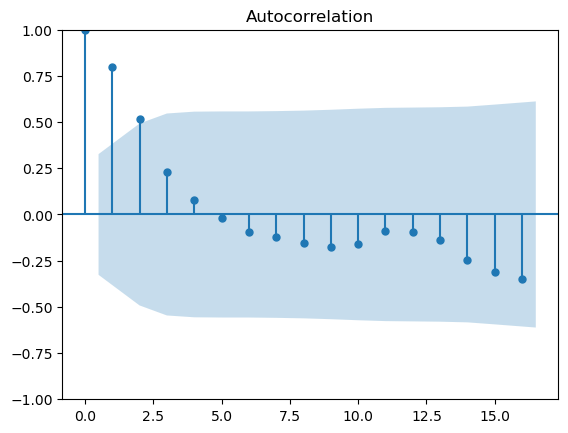

In [32]:
plot_acf(y_train);

The acf plot has identified that a seasonality value of either 2 or 3 will be good.

In [33]:
# Fit Auto ARIMA
shorterperiod_sarimax_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           D=None,
                           start_Q=0, max_Q=10,
                           m=3, 
                           seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

shorterperiod_sarimax_model.fit(y_train, X_train) # we were only fitting purely on y_train before, but now we are fitting on y_train and X_train to include exogenous features

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=617.208, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=600.071, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=602.394, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=620.421, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[3] intercept   : AIC=599.395, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[3] intercept   : AIC=599.389, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[3] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,2)[3] intercept   : AIC=599.427, Time=0.10 sec
 ARIMA(1,0,0)(1,0,2)[3] intercept   : AIC=601.678, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[3] intercept   : AIC=618.248, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[3] intercept   : AIC=597.154, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[3] intercept   : AIC=595.880, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[3] intercept   : AIC=597.885, Time=0.09 sec
 ARIMA(2,0,0)(1,0,1)[3] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[3] intercept   : AIC=inf, Time=0.0

AutoARIMA(m=3, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

The optimal value for seasonality was 3 in this case, but it doesn't matter as the MAPE score of 0.59 is worse than previous models.

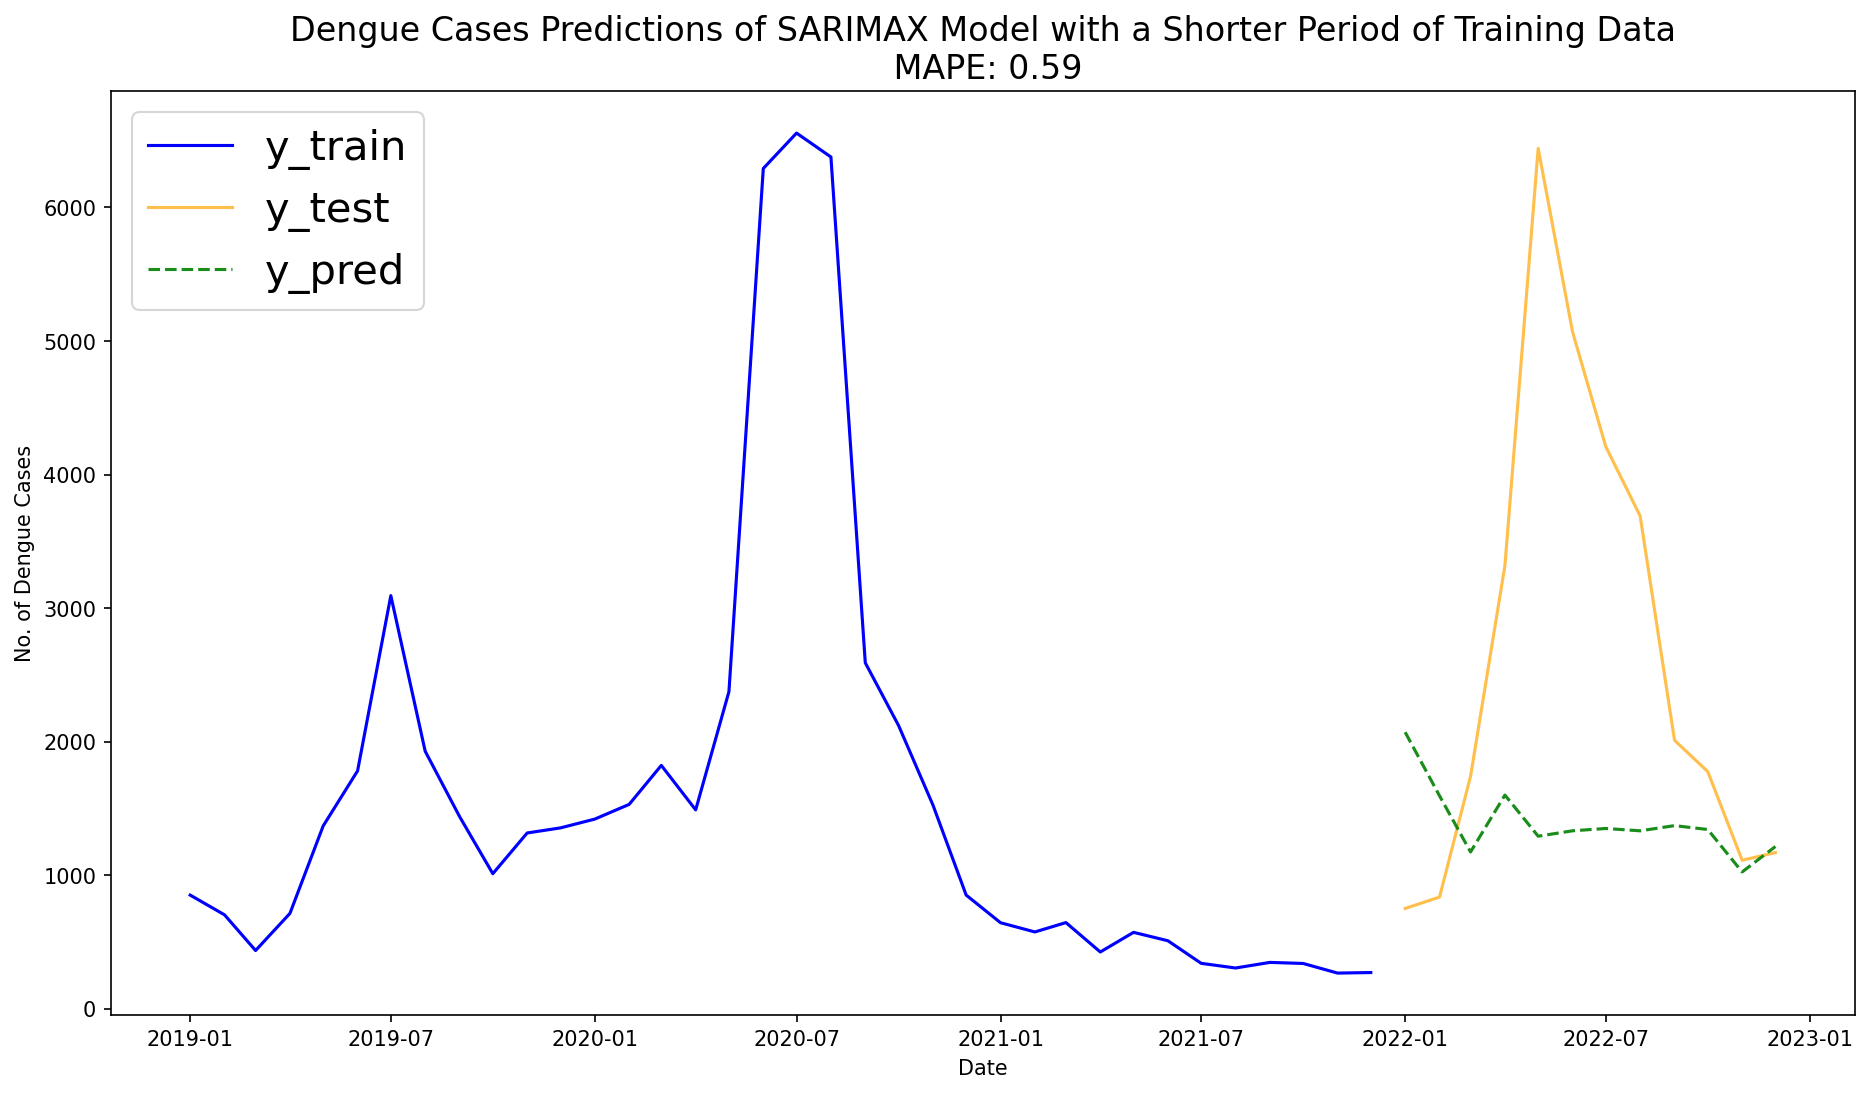

In [34]:
plot_forecast(y_train, y_test, shorterperiod_sarimax_model,'SARIMAX Model with a Shorter Period of Training Data', X_test);

So far, the models I have tried which use my exogenous features and trying to predict 1 year into the future have performed worse than my baseline model which just used dengue cases, and at best matching the MAPE score from the baseline model.

**Also note that every weather feature was insignificant, and google trends were also almost all deemed insignifcant. This coupled with my EDA done in the previous notebooks which showed that as we lag the data further back, the correlation gets worse. This suggests that both my google trends and weather data is not useful at all in predicting dengue cases.**

I may need to try using just dengue cases with more granularity (i.e. weekly dengue cases) to accurately predict dengue cases.

I will try one last model with exogenous features.

# Improved Model #4 - More Feature Engineered Features

I will now try to improve model performance by feature engineering additional an additional feature as we know that the peak season for dengue is in the months of [June or July.](https://www.nea.gov.sg/media/news/news/index/number-of-weekly-dengue-cases-expected-to-exceed-the-historical-high-of-891-unless-urgent-collective-community-action-is-taken)

1. peak_season will be the months of June and July of each year.


In [35]:
dengue_features_removed['peak_season'] = 0 # creating a new feature called peak_season as explained above.

In [36]:
dengue_features_removed.loc[(dengue_features_removed.index.month == 6) | (dengue_features_removed.index.month == 7),'peak_season'] = 1 # setting the relevant months to have a value of 1

In [37]:
dengue_features_removed.head(12)# notice peak_season has a value of 1 for the months of June and July.

search_dengue_fever  search_dengue  new_strain  \
Date                                                         
2013-01-01                  8.0            9.0         0.0   
2013-02-01                 10.0           11.0         0.0   
2013-03-01                 10.0            9.0         0.0   
2013-04-01                  8.0            9.0         0.0   
2013-05-01                  9.0           12.0         0.0   
2013-06-01                 11.0           11.0         0.0   
2013-07-01                 14.0           12.0         0.0   
2013-08-01                 11.0           10.0         0.0   
2013-09-01                 11.0            9.0         0.0   
2013-10-01                 12.0           11.0         0.0   
2013-11-01                 10.0           10.0         0.0   
2013-12-01                  9.0            8.0         0.0   

            number_of_dengue_cases  peak_season  
Date                                             
2013-01-01                     979            0  
2013-02-01                    1109            0  
2013-03-01                    1198            0  
2013-04-01                    2481            0  
2013-05-01                    2546            0  
2013-06-01                    3258            1  
2013-07-01                    2198            1  
2013-08-01                    1353            0  
2013-09-01                    1997            0  
2013-10-01                    1758            0  
2013-11-01                    1580            0  
2013-12-01                    1948            0

In [38]:
# Adding Exogenous variables to our model
X = dengue_features_removed.drop(['number_of_dengue_cases'],axis = 1)

# split `X` train and test for same timeframe as `y`
X_train = X.loc[:'2021']
X_test = X.loc['2022':]

# same steps as earlier to split `y`
y = dengue_features_removed['number_of_dengue_cases']

y_train = y.loc[:'2021']
y_test = y.loc['2022':]

I am training the model from the start instead of 2019 the model which was trained on the more recent years had poorer performance.

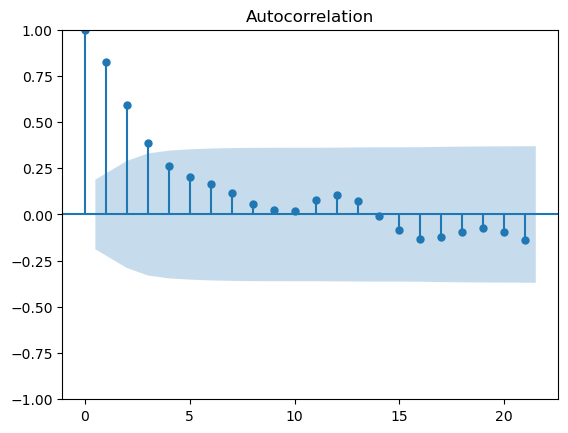

In [39]:
plot_acf(y_train);

The acf plot has identified that a seasonality value of either 2, 3, or 4 will be good.

In [40]:
# Fit Auto ARIMA
morefeatures_sarimax_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           D=None,
                           start_Q=0, max_Q=10,
                           m=4, 
                           seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

morefeatures_sarimax_model.fit(y_train, X_train) # we were only fitting purely on y_train before, but now we are fitting on y_train and X_train to include exogenous features

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1805.062, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=1697.921, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=1734.394, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1822.774, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=1695.818, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=1697.027, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=1692.523, Time=0.11 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=1695.020, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=1694.599, Time=0.14 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=1699.097, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[4] intercept   : AIC=1695.254, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=1695.132, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=1693.905, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[4] intercept   : 

AutoARIMA(m=4, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

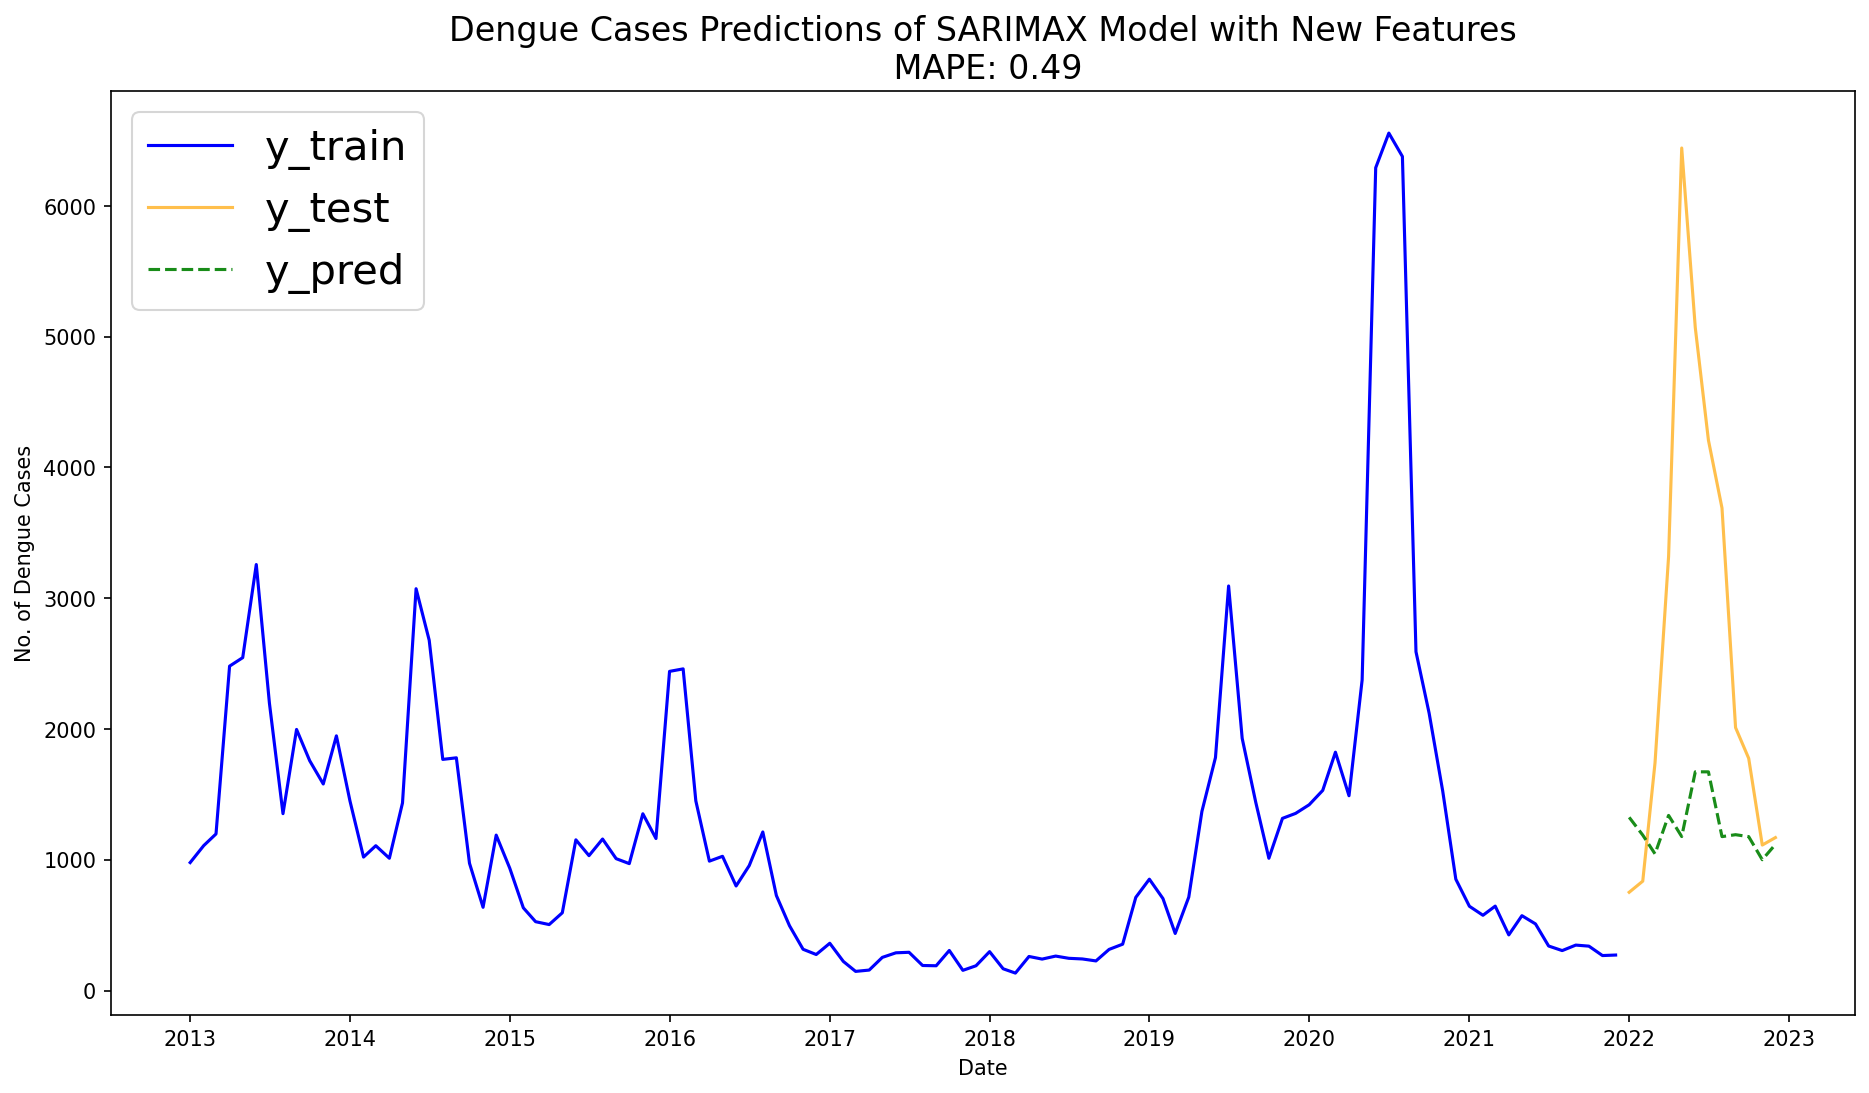

In [41]:
plot_forecast(y_train, y_test, morefeatures_sarimax_model,'SARIMAX Model with New Features', X_test);

This model with new features has shown the best MAPE score of 0.49 which is an improvement on the baseline model but nowhere near good enough in terms of predicting dengue cases.

I will need to try other methods.

# Improved Model #5 - Using Weekly Dengue Cases Only and Shorter Prediction Period

These are the following things I will try to improve model performance:

1. Explore the performance of models predicting 6 months into the future compared to a year into the future to see if it improves performance.

1. Focus on using just the preceding number of dengue cases to predict future dengue cases as my modelling has shown that the exogenous features of google trends and weather information is not useful in predicting dengue cases.

1. Use a more granular dataset (i.e. weekly dengue cases) as compared to monthly dengue cases to see if improves model performance.

1. Train the model on data from 2020 onwards for the same reason listed in improved model #3.

With these steps, the hope would be to improve model performance significantly.

In [42]:
weekly_cases = pd.read_csv('../data/inputs/Weekly_Dengue_Cases.csv',index_col=0)# reading in weekly dengue cases csv

In [43]:
weekly_cases = weekly_cases.drop('Dengue Haemorrhagic Fever',axis = 1)# dropping columns as previously described
weekly_cases['date'] = pd.to_datetime(weekly_cases['epi_week'])# converting to datetime
weekly_cases = weekly_cases.set_index('date')#setting date as index
weekly_cases = weekly_cases.drop('epi_week',axis = 1) # dropping column which is now no longer needed.
weekly_cases = weekly_cases.rename(columns={'Dengue Fever':'number_of_dengue_cases'})# rename columns for clarity.

In [44]:
weekly_cases.head() #Cleaned up weekly dengue cases dataframe

number_of_dengue_cases
date                              
2012-01-02                      74
2012-01-09                      64
2012-01-16                      60
2012-01-23                      50
2012-01-30                      84

In [45]:
weekly_cases.info() # final weekly dengue cases dataframe with no missing values.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 574 entries, 2012-01-02 to 2022-12-26
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   number_of_dengue_cases  574 non-null    int64
dtypes: int64(1)
memory usage: 9.0 KB


In [46]:
weekly = weekly_cases.copy()# creating a copy of the original dataframe

weekly = weekly_cases[-52*3:] # setting the dataframe to be only 2020 data onwards (52 weeks in a year, so -52 * 3 would be 2022, 2021, and 2020 data)
y_train = weekly[:-26] # setting the training data to include 2020, 2021, and 2022 date up to the last 6 months (i.e. 26 weeks = half a year = 6 months)
y_test = weekly[-26:] # setting the testing data to be last the 6 months of the year 2022.

In [47]:
print(y_train.head())
print(y_train.tail())# note the end of y_train ends 6 months into 2022.

            number_of_dengue_cases
date                              
2020-01-06                     342
2020-01-13                     402
2020-01-20                     307
2020-01-27                     370
2020-02-03                     400
            number_of_dengue_cases
date                              
2022-05-30                    1451
2022-06-06                    1459
2022-06-13                    1253
2022-06-20                    1171
2022-06-27                    1186


In [48]:
print(y_test.head()) # note that y_test starts from 6 months in (i.e. July onwards).

            number_of_dengue_cases
date                              
2022-07-04                    1164
2022-07-11                     918
2022-07-18                    1035
2022-07-25                    1092
2022-08-01                     894


Visually confirming that the train test split is correctly done, and it is. The train set is from 2020 - 2022 June and the test set is from 2022 July onwards.

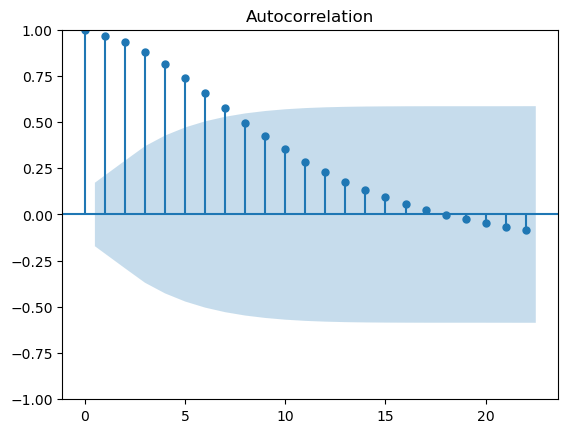

In [49]:
plot_acf(y_train); # determining the value for my seasonality parameter in the upcoming SARIMA model.

In [50]:
# Fit Auto ARIMA
weekly_sarima_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           D=None,
                           start_Q=0, max_Q=10,
                           m=5, 
                           seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

weekly_sarima_model.fit(y_train) # we were only fitting purely on y_train before, but now we are fitting on y_train and X_train to include exogenous features

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=1969.688, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=1576.695, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=1783.492, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=2053.407, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=1575.592, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=1576.692, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=1578.688, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[5] intercept   : AIC=1577.529, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=1577.560, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=1841.984, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[5] intercept   : AIC=1572.476, Time=0.06 sec
 ARIMA(2,0,1)(1,0,0)[5] intercept   : AIC=1568.715, Time=0.15 sec
 ARIMA(2,0,1)(2,0,0)[5] intercept   : AIC=1569.324, Time=0.16 sec
 ARIMA(2,0,1)(1,0,1)[5] intercept   : AIC=1570.084, Time=0.15 sec
 ARIMA(2,0,1)(0,0,1)[5] intercept

AutoARIMA(m=5, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

The best model performance I got was from setting seasonality to 5.

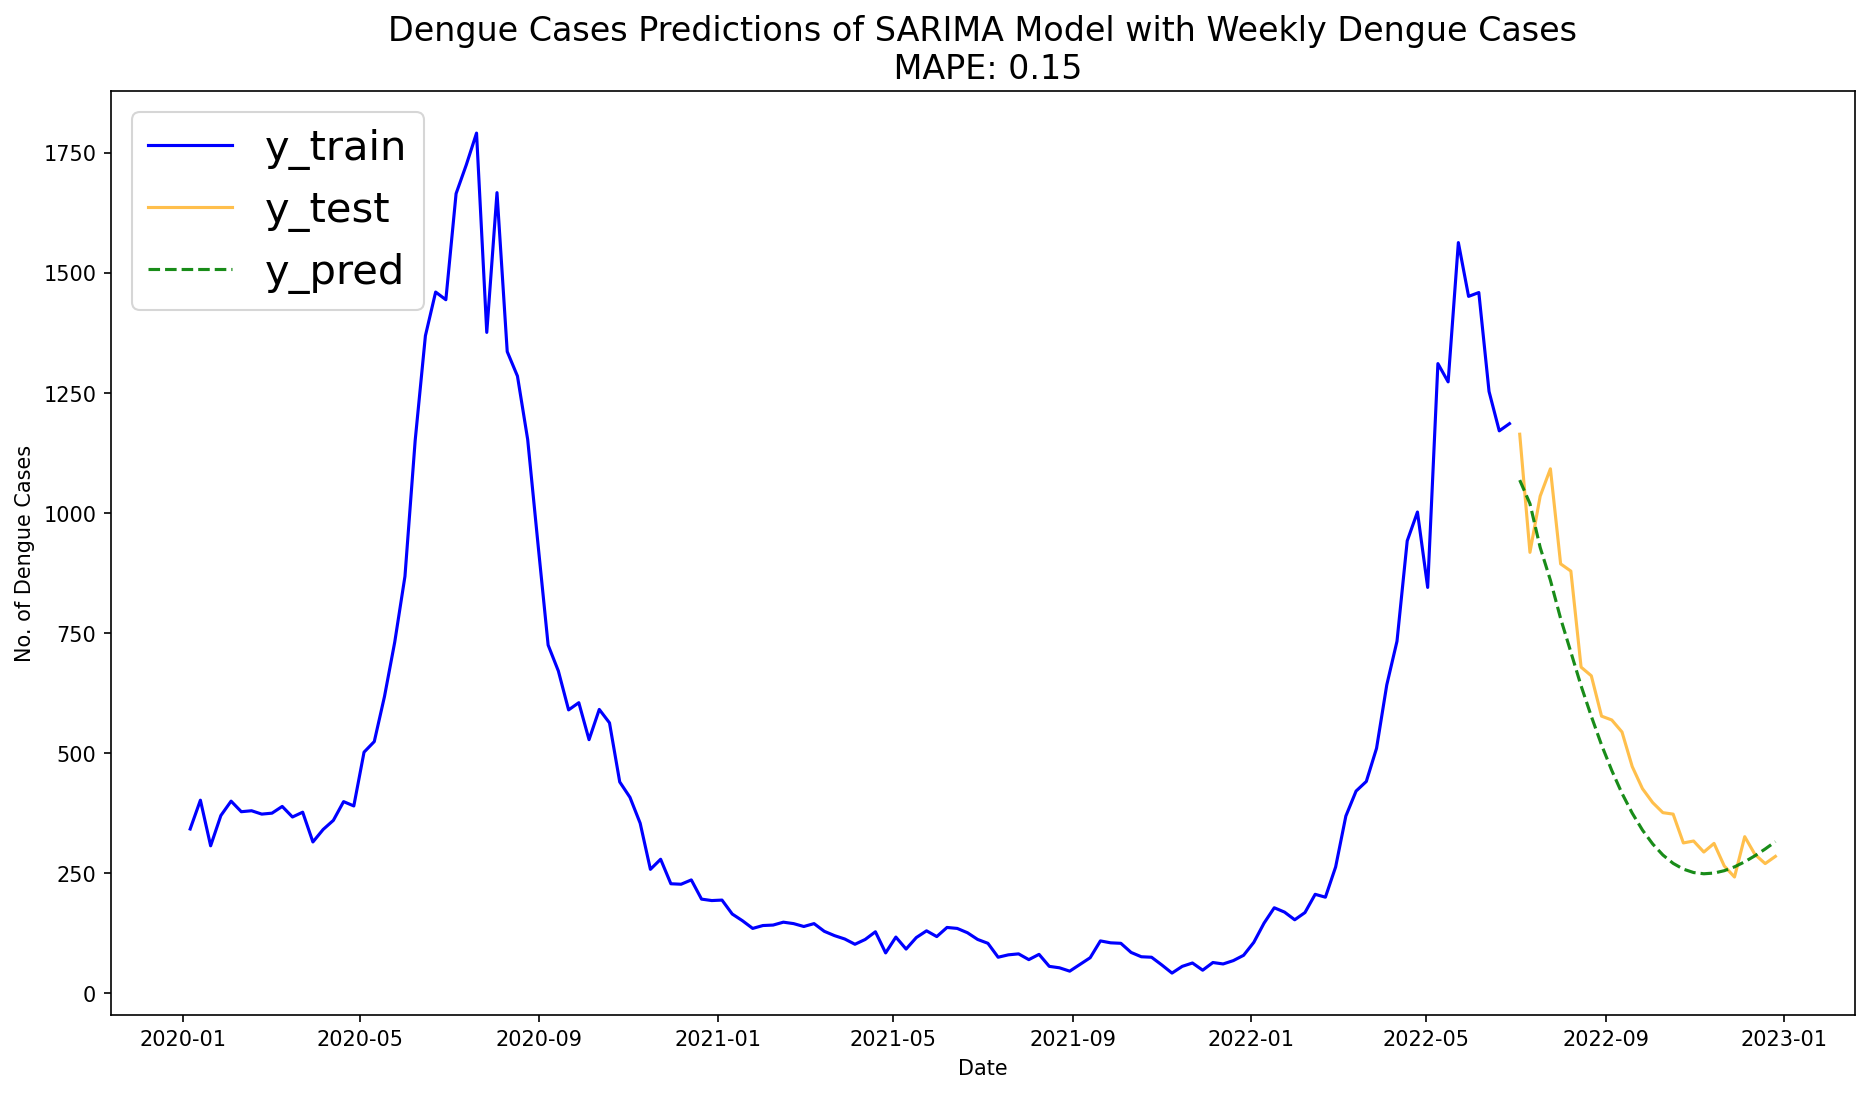

In [51]:
# invoke the helper function to visualize Auto ARIMA model predictions
plot_forecast(y_train, y_test, weekly_sarima_model, 'SARIMA Model with Weekly Dengue Cases')

We have created a model with good performance. This model is able to predict 6 months / 26 weeks into the future with a MAPE score of 0.15. 
This is our best model that will be presented to the NEA for implementation.

# Summary of Models & Selecting Best Model

|  | Baseline Model | Improved Model #1 | Improved Model #2 | Improved Model #3 | Improved Model #4 | Improved Model #5 (BEST MODEL) |
|---|---|---|---|---|---|---|
| Model | ARIMA | ARIMAX | SARIMAX | SARIMAX | SARIMAX | SARIMA |
| Training Data | Monthly Dengue Cases from 2012 - 2021 | Monthly Dengue Cases from 2013 - 2021<br><br>Including Exogenous Features shifted by a year:<br>1. Google Trends<br>2. Weather Information<br>3. Feature Engineered Features | Monthly Dengue Cases from 2013 - 2021<br><br>Including Exogenous Features shifted by a year:<br>1. Google Trends<br>2. Weather Information<br>3. Feature Engineered Features<br>- Insignificant features were removed | Monthly Dengue Cases from 2019 - 2021<br><br>Including Exogenous Features shifted by a year:<br>1. Google Trends<br>2. Weather Information<br>3. Feature Engineered Features<br>- Insignificant features were removed<br><br>Training Data from a more recent time period | Monthly Dengue Cases from 2013 - 2021<br><br>Including Exogenous Features shifted by a year:<br>1. Google Trends<br>2. Weather Information<br>3. More Feature Engineered Features<br>- Insignificant features were removed | Weekly Dengue Cases from 2020 - 2022 Jun |
| Test Data | Entire Year 2022 | Entire Year 2022 | Entire Year 2022 | Entire Year 2022 | Entire Year 2022 | Jul - Dec 2022 (6 months or 26 weeks) |
| MAPE Score | 0.50 | 0.59 | 0.50 | 0.59 | 0.49 | 0.15 |


The summary of models I've fitted is shown above and the **best model is Improved Model #5.**

The best model was chosen based on its MAPE Score.

The best model had a MAPE score of 0.15 which means that the predicted values were off by only 15% compared to the actual values for the predictions period, which in this case is the last 6 months of 2022. This is a huge improvement from my baseline model with a MAPE score of 0.50.

I will now perform a cost-benefit analysis for my stakeholder, the NEA to quantify the benefits of this model.

# Cost-Benefit Analysis

To begin this cost-benefit analysis, I first researched how much money NEA spends on just inspections each year.
To begin this cost-benefit analysis, we first researched how much money NEA spends on just inspections each year.

**Cost Savings:**
1. According to NEA, they performed around [911,000 inspections islandwide in 2022](https://www.nea.gov.sg/media/news/news/index/nea-launches-national-dengue-prevention-campaign-early-urge-vigilance-avert-dengue-outbreak-2023) for any signs of dengue. Each inspection usually takes up to [15 minutes according to an inspector from NEA depending on the layout of the home](https://www.straitstimes.com/singapore/environment/what-to-expect-when-nea-knocks-on-your-door-for-a-dengue-inspection#:~:text=The%20entire%20inspection%20process%20usually,common%20breeding%20spots%20of%20mosquitoes.). To be conservative I will take 10 minutes instead of 15 minutes per inspection. The hourly rate for the inspectors doing the inspection will be on the [extremely conservative end of SGD8.50 per hour](https://www.mycareersfuture.gov.sg/job/environment/temp-management-support-officer-x-100-business-edge-personnel-services-0a908103d7fe557515595ca8d8811ddf) as according to a job post on the government run job portal looking for dengue support officers, the pay listed there is SGD8.50 per hour. However the posting was looking for people to support the actual inspectors, so naturally the inspectors would command a higher hourly pay. I couldn't find any official source regarding the inspection officer's pay so I will stick to using SGD8.50 per hour. 
    1. (911,000 inspections * 10 minutes per inspection) = 9,110,000 minutes
    1. 9,110,000 minutes / 60  = 151833 hours.
    1. **151833 * 8.50 = SGD 1,290,583 spent to do inspections in year 2022.**

With the model we have developed, the NEA can reduce inspections for certain months based on the model's prediction.
For example, if the model predicted the next 6 months to have very low cases of dengue, the NEA could do fewer inspections than they usually do as they can be confident that the number of cases won't be too far off the predicted cases. This is as our model has an MAPE score of 0.15.

**Even with just a 10% reduction in inspections, the NEA could save SGD 129,000 per year.** At the very least, if the NEA doesn't want to reduce spending in combating dengue through reducing inspections, they can reallocate their resources to the months with predicted high number of cases rather than wasting it on months with low cases.

Besides the direct cost savings that NEA can benefit from implementing the model, there are also more potential benefits listed below.

**More Benefits**
1. Timely Campaigns:
The ability to accurately predict dengue cases allows NEA to proactively plan and implement preventive measures. By identifying high-risk periods, NEA can intensify public awareness campaigns such as their National Dengue Prevention Campaign, distribute educational materials, and engage communities in taking preventive actions just before these high-risk period. This proactive approach can lead to reduced dengue transmission, lower healthcare costs, and better overall public health outcomes.

1. Mitigating Economic Impact:
Dengue outbreaks have significant economic consequences due to increased healthcare expenses and productivity losses. It is estimated that the cost of Dengue between the year [2010 - 2020 is  between 1 - 2 billion dollars](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10021432/#:~:text=We%20estimated%20that%20the%20average,21%2C262%20DALYs%20from%202010%E2%80%932020.). By implementing our model, the NEA can anticipate potential outbreaks and take timely measures to mitigate their impact. These proactive actions can help minimize the economic burden associated with dengue outbreaks.

In conclusion, our dengue cases prediction model, with its MAPE score of 0.15, offers significant cost reductions and other benefits to the NEA. The model enables cost savings through optimized inspection allocation, improves operational efficiency, mitigates the economic impact of outbreaks, and enhances overall resource allocation. By harnessing the power of data-driven predictions, NEA can make informed decisions, allocate resources more effectively, and improve public health outcomes in the fight against dengue.

# Conclusions and Recommendations


To conclude, we have achieved our main goal as indicated in the problem statement of creating a machine learning model capable of forecasting the number of dengue cases in Singapore. We developed a model which is able to predict the number of dengue cases across a six month period with a MAPE score of 0.15. We have also conducted a cost-benefit analysis and quantified the benefits which implementing our model will bring.

Recommendations for future work is as follows:
1. We can add a feature related to social responsibility, such as the number of households or businesses [fined for being dengue breeding grounds](https://www.nea.gov.sg/dengue-zika/inspecting-your-homes-and-premises-for-mosquito-habitats#:~:text=If%20your%20premises%20are%20found,and%20Pesticides%20Act%20(CVPA).). This can be a valuable addition for future models as this feature captures an aspect of community engagement and compliance with dengue prevention measures, which can have a significant impact on the overall dengue transmission dynamics. 

1. We can also include more granular location data and consider developing a model which will give predictions for multiple areas across Singapore. This is as the current dataset is information across the whole of Singapore, and the predicted dengue cases are also across the whole of Singapore. With this suggested model, it would be able to predict the number of dengue cases across different areas of Singapore, which would be useful for the NEA to know the exact dengue hotspots to focus their efforts on rather than a blanket approach which may not be as effective..
    1. An example of the kind of data which should be included in future models would be the sites where [Project Wolbachia,](https://www.nea.gov.sg/corporate-functions/resources/research/wolbachia-aedes-mosquito-suppression-strategy/frequently-asked-questions#:~:text=Project%20Wolbachia%20%E2%80%93%20Singapore%20suppresses%20urban,aegypti%20mosquitoes%20do%20not%20hatch.) which is NEA's Mosquito Suppression Strategy have been implemented. This is as their data has shown that in the areas which have implemented this project for more than a year, there have been up to an [88 percent decrease in the number of dengue case.](https://www.nea.gov.sg/media/news/news/index/nea-s-project-wolbachia-singapore-to-be-expanded-to-eight-additional-sites#:~:text=The%20eight%20locations%20are%20Bedok,Multi%2Dsite%20Field%20Study) Meaning that if a particular area is a Project Wolbachia site, the number of dengue cases there is expected to be much lower compared to areas where the project is not present.